In [1]:
import os
import re
import nltk
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from datetime import datetime
from string import whitespace, punctuation
from spacy.tokens.doc import Doc
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
import tensorflow as tf
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, TextVectorization, Input, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from typing import Iterable, Generator, List

In [2]:
sns.set_style("darkgrid", {'axes.grid' : True})

# Define global variables & constants

In [2]:
COLUMNS = ['Subject', 'Message', 'Is Fraudulent']
DATABASE_PATH = r'..\resources\database'
LSTM_PATH = r'..\models\LSTM'
SAVE_MODEL = False

# Load the dataset

In [4]:
emails_xlsx = os.path.join(DATABASE_PATH, 'emails-database.xlsx')

In [5]:
emails_df1 = pd.read_excel(emails_xlsx, usecols=['Subject', 'Raw Message', 'Is Phishy'], converters={'Is Phishy': int})

In [6]:
emails_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6558 entries, 0 to 6557
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Subject      6446 non-null   object
 1   Raw Message  6516 non-null   object
 2   Is Phishy    6558 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 153.8+ KB


# Load the second dataset

In [7]:
emails_zip = os.path.join(DATABASE_PATH, 'fraud_email_.csv.zip')

In [8]:
emails_df2 = pd.read_csv(emails_zip, converters={'Class': int})

Prepend empty 'Subject' column so that the dimensions and columns order match for joining

In [9]:
emails_df2.insert(loc=0, column='Subject', value=np.full(shape=(emails_df2.shape[0],), fill_value=np.nan))

In [10]:
emails_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11929 entries, 0 to 11928
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Subject  0 non-null      float64
 1   Text     11928 non-null  object 
 2   Class    11929 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 279.7+ KB


# Join tables

In [11]:
emails_df = pd.DataFrame(np.r_[emails_df1, emails_df2], columns=COLUMNS)

# Analyze textual data
Remove any rows where either Raw Message or Phishy is missing.

In [12]:
emails_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18487 entries, 0 to 18486
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Subject        6446 non-null   object
 1   Message        18444 non-null  object
 2   Is Fraudulent  18487 non-null  object
dtypes: object(3)
memory usage: 433.4+ KB


In [13]:
emails_df.dropna(how='any', subset=['Message', 'Is Fraudulent'], inplace=True)

> Note that after text preprocessing, the number of empty documents might increase. Therefore, additional removal of empty documents from the corpus should be executed after preprocessing!

In [14]:
phishy_freqs = emails_df['Is Fraudulent'].value_counts()

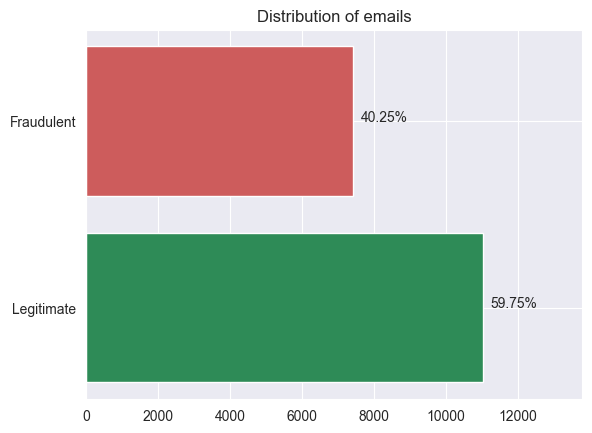

In [15]:
plt.barh(y=phishy_freqs.index, width=phishy_freqs.values, color=['seagreen', 'indianred'], align='center')
plt.title('Distribution of emails')
plt.yticks([0, 1], ['Legitimate', 'Fraudulent'])
plt.xlim([0, phishy_freqs.max() * 1.25])
 
# Text right-aligned to each horizontal bar
labels = ["{:.2f}%".format((f / phishy_freqs.sum()) * 100) for f in phishy_freqs]
for i, label in enumerate(labels):
    plt.text(x = phishy_freqs[i] + 200, y = i, s = label, size = 10)
 
plt.show()

## Perform stratified shuffle split

In [16]:
# Feature matrix must be multidimensional as it is propagated through a pipeline to transformers
X = emails_df[['Subject', 'Message']] # .sample(1000, random_state=33)
y = emails_df['Is Fraudulent'].astype(int) # .sample(1000, random_state=33)

In [17]:
# Train, test, validation split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=33)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify=y_test, test_size=0.5, random_state=33)

# Preprocess text
As part of preprocessing, we need to
perform case-folding, stopword removal. We will not keep single-character words. It might be advantagous to lemmatize words as well. 
Empty rows resulting from text preprocessing should be removed.

In [18]:
class SpacyPreprocessor(BaseEstimator, TransformerMixin):
    """
    Description
        Class for text preprocessing. Designed for Pipelines and Column Transformers.
    Arguments:
        - mode [str]: Determine how to exclude tokens based on allowed characters
            'all' yields all tokens
            'alpha' yields only alphabetical tokens
            'alnum' yields alphanumerical tokens 
            'ascii' yields any ascii-compliant tokens
            'non_num' yields everything except for number-like tokens
        - min_length [int]: Tokens with length shorter than this value are excluded.
        - keep_stop [bool]: If true, stopwords are kept. By default stopwords are removed.
    """
    def __init__(self, mode: str = 'all', min_length: int = 0, keep_stop: bool = False):
        super(SpacyPreprocessor, self).__init__()
        self.nlp = spacy.load(
            name='en_core_web_sm', 
            disable=["parser", "ner"]
        )
        self.mode = mode
        self.min_length = min_length
        self.keep_stop = keep_stop


    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        return X.apply(self.preprocess_corpus)
    
    def preprocess_corpus(self, corpus: List[str]) -> list:
        return [
            # Join preprocessed docs
            ' '.join(self.preprocess_document(doc))
            # Apply initial sentence-level cleaning
            for doc in self.nlp.pipe(self.clean_document(text=str(x)) for x in corpus)
        ]

    def preprocess_document(self, doc: Doc) -> Generator[str, None, None]:
        # Tokenize document
        for token in doc:
            # Keep in mind that high frequency of extremely short tokens might indicate fraudulent email
            if not len(token.text) >= self.min_length:
                continue

            # Exclude any non-alphanumeric tokens
            # Keep in mind that high frequency of tokens consisting of special characters might indicate fraudulent email
            if self.mode == 'alnum' and not token.text.isalnum():
                continue

            # Exclude non-ASCII tokens
            # Keep in mind that high frequency of non-ascii characters might indicate fraudulent email
            if self.mode == 'ascii' and not token.is_ascii:
                continue 

            # Exclude non-alphabetic tokens
            # Keep in mind that it limits the vocabulary to alphabetic tokens only, significantly affecting the spectrum of characters
            if self.mode == 'alpha' and not token.is_alpha:
              continue
            
            # Exclude numeric-like tokens
            # Keep in mind that high frequency of numeric-like tokens might indicate fraudulent email
            if self.mode == 'non_num' and token.like_num:
                continue
            
            # Exclude stopwords
            if not self.keep_stop and token.is_stop:
                continue
              
            # Lemmatization
            lemma = token.lemma_

            # Yield lemma
            yield lemma

    @staticmethod
    def clean_document(text: str) -> str:
        # Clean each word
        words = map(
            lambda s: SpacyPreprocessor.clean_word(s), 
            text.casefold().split()
        )
        # Replace multiple whitespaces with a single space
        return ' '.join(filter(lambda s: bool(s), words))

    @staticmethod
    def clean_word(word: str) -> str:
        return re.sub(
            # Remove any unicode characters
            r"_x([0-9a-fA-F]{4})_", '', word
        # Strip leading or trailing whitespaces & punctuation marks
        # But leave any non-alphanumeric characters within words
        ).strip(whitespace + punctuation)

In [19]:
class TextAttribConcat(BaseEstimator, TransformerMixin): 
    
    """
    Description:
      Concatenate multiple columns into a new one by joining the rows with a defined separator.

    Parameters:
        - attribs_in: List[str] = list of input features to concatenate.
        - attrib_out: str = feature to add.
        - sep: str = separator that joins string content in selected columns.
    
    Usage:
        Transformation step in the pipeline.
    
    Example:
        Let's assume the input feature matrix consists of two columns: ['Title', 'Description']
        We want to concatenate the text content of these columns into one: 'All Details'
        The pipeline should be initialized as:
            
            sklearn.pipe.Pipeline(steps=[
                ...,
                ('all_details', TextAttribConcat(attribs_in=['Title', 'Description'], attrib_out='All Details', sep='-')),
                ...
            ])
    """

    def __init__(self, attribs_in: List[str], attrib_out: str, sep: str = '\n'):
        super(TextAttribConcat, self).__init__()
        self.attribs_in = attribs_in
        self.attrib_out = attrib_out
        self.sep = sep
    
    def fit(self, X , y=None):
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        # Fill NaNs with empty string, explicitly convert columns to string dtype and join values
        X_ = X[self.attribs_in].fillna('').astype(str).agg(self.sep.join, axis=1)
        return pd.DataFrame(
            data=np.c_[X, X_],
            columns=[*X.columns, self.attrib_out]
        )

In [240]:
text_preprocessor = make_pipeline(
    SpacyPreprocessor(mode='non_num', min_length=2), 
    FunctionTransformer(pd.DataFrame.dropna)
)

In [241]:
pipe = Pipeline(steps=[
    ('text_concat', TextAttribConcat(attribs_in=['Subject', 'Message'], attrib_out='Email Content', sep='\n')),
    ('text_preprocess', make_column_transformer((text_preprocessor, ['Email Content'])))
])

In [242]:
X_train_clean = pipe.fit_transform(X_train)
X_test_clean, X_val_clean = [pipe.transform(x) for x in (X_test, X_val)]

# Analyze training corpus

In [243]:
from itertools import chain

In [244]:
def get_all_words(corpus: Iterable) -> list:
    return list(chain(*[doc.split() for doc in corpus if doc]))

In [245]:
all_words = get_all_words(X_train_clean.flatten())

In [246]:
vocab = nltk.FreqDist(all_words)
vocab_20 = pd.Series(dict(vocab.most_common(20)))

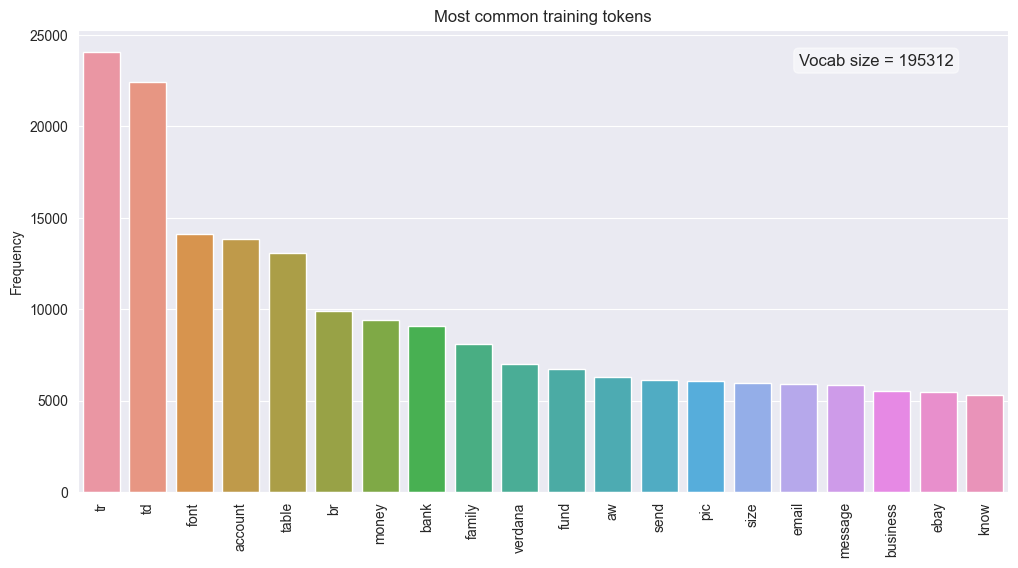

In [247]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=vocab_20.index, y=vocab_20.values, ax=ax)

props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.775, 0.95, f'Vocab size = {len(vocab)}', transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

ax.set_title('Most common training tokens')
ax.set_ylabel('Frequency')
plt.xticks(rotation=90)

plt.show()

In [248]:
trigrams = nltk.trigrams(all_words)
trigram_freqs_20 = pd.Series({
    '_'.join(k): v for k, v in sorted(nltk.FreqDist(trigrams).most_common(20), key=lambda item:item[1], reverse=True)
})

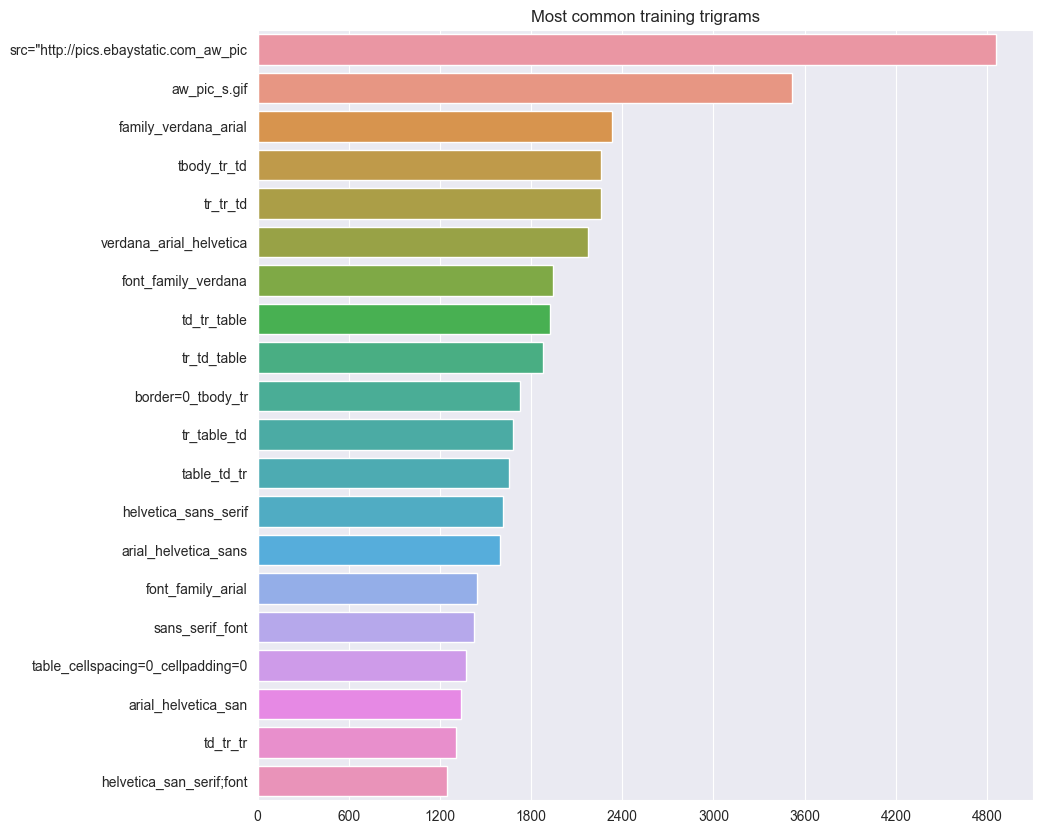

In [249]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x=trigram_freqs_20.values, y=trigram_freqs_20.index, orient='h', ax=ax)
ax.set_title('Most common training trigrams')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

# RNN Architecture

In [250]:
# Prepare training dataset
train_text, train_labels = (
    tf.data.Dataset.from_tensor_slices(x) for x in (X_train_clean, y_train)
)
train_ds = tf.data.Dataset.zip(datasets=(train_text, train_labels))

In [251]:
# Prepare validation dataset
val_ds = tf.data.Dataset.from_tensor_slices(tensors=(X_val_clean, y_val))

In [252]:
# Prepare testing dataset
test_ds = tf.data.Dataset.from_tensor_slices(tensors=(X_test_clean, y_test))

In [3]:
# Vocabulary size
VOCAB_SIZE = 35000

# Max number of words for each sequence
MAX_LEN = 250

# Max embedding size
EMBED_DIM = 100

# Set batch size
BATCH_SIZE = 256

# Set n-grams
N_GRAMS = 3

# Set number of epochs for training
EPOCHS = 30

# Learning rate
LR = 1e-2

Build the model

In [4]:
class LSTMClassifier(Model):
    
    """
    Description
        LSTM model for multi-category classification.
    
    Arguments
        - n_classes [int]: Number of output categories
        - vocab_size [int]: Vocabulary size. By default 50 000.
        - max_seq_len [int]: Max number of words for each sequence. By default 250.
        - embed_dim [int]: Max embedding size. By default 100.
        - n_grams [int]: Number of tokens to embed into ngrams vector. By default 2.
    """
    
    def __init__(self, n_classes: int = 2, vocab_size: int = 50000, max_seq_len: int = 250, embed_dim: int = 100, n_grams: int = 2):
        # Call parent constructor
        super(LSTMClassifier, self).__init__()
        
        # Assign variables to parameters
        self.n_classes = n_classes
        self.vocab_size = vocab_size
        self.max_seq_len = max_seq_len
        self.embed_dim = embed_dim
        self.n_grams = n_grams      
        
        # Define layers
        self.input_layer = Input(
            name='inputs', 
            shape=(1,), 
            dtype=tf.string
        )
        self.vectorize_layer = TextVectorization(
            max_tokens=self.vocab_size, 
            output_mode='int', 
            output_sequence_length=self.max_seq_len, 
            ngrams=self.n_grams,
            pad_to_max_tokens=True,
            name='vectorization_layer'
        )
        self.embedding_layer = Embedding(
            input_dim=self.vocab_size + 1, 
            output_dim=self.embed_dim,
            name='embedding_layer'
        )
        self.spatial_dropout = SpatialDropout1D(rate=0.2)
        self.lstm_1 = LSTM(
            units=128, 
            dropout=0.2, 
            recurrent_dropout=0.2, 
            name='lstm_layer_01'
        )
        self.dense_1 = Dense(
            units=32, 
            activation='relu',
            name='dense_layer_01'
        )
        self.dropout_1 = Dropout(0.5)
        self.classifier = Dense(
            units=self.n_classes, 
            activation='softmax', 
            name='outputs'
        )
    
    def call(self, inputs):        
        # TextVectorization layer is used to normalize, split, and map strings to integers (set `output_mode` to `int`), thus needs to be instantiated before calling the model.
        # This layer transforms input document into a tensor of shape (batch_size, max_len) containing vocab indices.
        # Explicitly set maximum sequence length, as the LSTM layers do not support ragged sequences.
        # These layers are non-trainable, thus their state (vocabulary) must be set before training.
        # The vocabulary for that layer must be either supplied on construction (precomputed constant) or learned via adapt().
        # Furthermore, TextVectorization layer uses an underlying StringLookup layer that also needs to be initialized beforehand. 
        # Otherwise, FailedPreconditionError: Table not initialized exception is raised.
        x = self.vectorize_layer(inputs)

        # Embedding layer is mapping those vocab indices into a space of dimensionality (embedding_dim,). 
        # Note that we're using max_features + 1 here, since there's an OOV token that is added to the vocabulary in vectorize_layer.
        x = self.embedding_layer(x)

        # SpatialDropout1D performs variational dropout in NLP models.
        x = self.spatial_dropout(x)

        # While using multiple LSTM layers, the preceeding LSTM layer needs to return sequences.
        # Then, these sequences are passed as input to the next LSTM layer.
        x = self.lstm_1(x)

        # Following Dense layers increase the model's capacity to capture complex relationships
        # A dropout layer is used for regulating the network and keeping it as away as possible from any bias.
        x = self.dense_1(x)
        x = self.dropout_1(x)

        # The output Dense layer with a softmax activation function returns prediction probability for each category.
        return self.classifier(x)

    def build_graph(self):
        # Helper function to plot the model summary information conveniently.
        x = self.input_layer
        return Model(inputs=x, outputs=self.call(x))

    def compute_vocabulary(self, text_dataset: tf.data.Dataset):
        # Computes a vocabulary of string terms from tokens in a dataset.
        # It is necessary to supply vocabulary to the TextVectorization layer, whenever a model is instantiated (before fitting).
        self.vectorize_layer.adapt(text_dataset)

In [255]:
lstm = LSTMClassifier(vocab_size=VOCAB_SIZE, n_grams=N_GRAMS)
lstm.compute_vocabulary(train_text.batch(BATCH_SIZE))

In [256]:
lstm.compile(
    # Because it is a binary-class classification problem, binary_crossentropy is used as the loss function.
    # loss='binary_crossentropy',
    # However, we want to get the category index of the most like matching category.
    # Since our labels are integers and are not one-hot encoded, the sparse categorical crossentropy is used.
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=LR),
    metrics=['accuracy']
)

In [257]:
lstm.build_graph().summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1)]               0         
                                                                 
 vectorization_layer (TextVe  (None, 250)              0         
 ctorization)                                                    
                                                                 
 embedding_layer (Embedding)  (None, 250, 100)         3500100   
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 250, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_layer_01 (LSTM)        (None, 128)               117248    
                                                                 
 dense_layer_01 (Dense)      (None, 32)                4128

In [258]:
checkpoints_path = os.path.join(LSTM_PATH, 'checkpoints', datetime.now().strftime(r"%Y%m%d%H%m"))

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-4, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-4, verbose=1),
    ModelCheckpoint(filepath=checkpoints_path, monitor='val_loss', save_best_only=True, verbose=1)
]

In [259]:
history = lstm.fit(
    train_ds.batch(BATCH_SIZE), 
    validation_data=val_ds.batch(BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=callbacks
).history

Epoch 1/30
58/58 [==============================] - ETA: 0s - loss: 0.3716 - accuracy: 0.8671
Epoch 1: val_loss improved from inf to 0.24739, saving model to ..\models\LSTM\checkpoints\202210031510
INFO:tensorflow:Assets written to: ..\models\LSTM\checkpoints\202210031510\assets


INFO:tensorflow:Assets written to: ..\models\LSTM\checkpoints\202210031510\assets


58/58 [==============================] - 198s 3s/step - loss: 0.3716 - accuracy: 0.8671 - val_loss: 0.2474 - val_accuracy: 0.9214 - lr: 0.0100
Epoch 2/30
58/58 [==============================] - ETA: 0s - loss: 0.2289 - accuracy: 0.9241
Epoch 2: val_loss improved from 0.24739 to 0.18906, saving model to ..\models\LSTM\checkpoints\202210031510
INFO:tensorflow:Assets written to: ..\models\LSTM\checkpoints\202210031510\assets


INFO:tensorflow:Assets written to: ..\models\LSTM\checkpoints\202210031510\assets


58/58 [==============================] - 195s 3s/step - loss: 0.2289 - accuracy: 0.9241 - val_loss: 0.1891 - val_accuracy: 0.9588 - lr: 0.0100
Epoch 3/30
58/58 [==============================] - ETA: 0s - loss: 0.1296 - accuracy: 0.9690
Epoch 3: val_loss improved from 0.18906 to 0.06848, saving model to ..\models\LSTM\checkpoints\202210031510
INFO:tensorflow:Assets written to: ..\models\LSTM\checkpoints\202210031510\assets


INFO:tensorflow:Assets written to: ..\models\LSTM\checkpoints\202210031510\assets


58/58 [==============================] - 192s 3s/step - loss: 0.1296 - accuracy: 0.9690 - val_loss: 0.0685 - val_accuracy: 0.9772 - lr: 0.0100
Epoch 4/30
58/58 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.9835
Epoch 4: val_loss improved from 0.06848 to 0.05736, saving model to ..\models\LSTM\checkpoints\202210031510
INFO:tensorflow:Assets written to: ..\models\LSTM\checkpoints\202210031510\assets


INFO:tensorflow:Assets written to: ..\models\LSTM\checkpoints\202210031510\assets


58/58 [==============================] - 198s 3s/step - loss: 0.0656 - accuracy: 0.9835 - val_loss: 0.0574 - val_accuracy: 0.9821 - lr: 0.0100
Epoch 5/30
58/58 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9870
Epoch 5: val_loss improved from 0.05736 to 0.05517, saving model to ..\models\LSTM\checkpoints\202210031510
INFO:tensorflow:Assets written to: ..\models\LSTM\checkpoints\202210031510\assets


INFO:tensorflow:Assets written to: ..\models\LSTM\checkpoints\202210031510\assets


58/58 [==============================] - 192s 3s/step - loss: 0.0450 - accuracy: 0.9870 - val_loss: 0.0552 - val_accuracy: 0.9827 - lr: 0.0100
Epoch 6/30
58/58 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.9875
Epoch 6: val_loss did not improve from 0.05517
58/58 [==============================] - 189s 3s/step - loss: 0.0373 - accuracy: 0.9875 - val_loss: 0.0596 - val_accuracy: 0.9810 - lr: 0.0100
Epoch 7/30
58/58 [==============================] - ETA: 0s - loss: 0.0255 - accuracy: 0.9902
Epoch 7: val_loss did not improve from 0.05517
58/58 [==============================] - 187s 3s/step - loss: 0.0255 - accuracy: 0.9902 - val_loss: 0.0606 - val_accuracy: 0.9843 - lr: 0.0100
Epoch 8/30
58/58 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9909
Epoch 8: val_loss improved from 0.05517 to 0.05457, saving model to ..\models\LSTM\checkpoints\202210031510
INFO:tensorflow:Assets written to: ..\models\LSTM\checkpoints\202210031510\assets


INFO:tensorflow:Assets written to: ..\models\LSTM\checkpoints\202210031510\assets


58/58 [==============================] - 192s 3s/step - loss: 0.0192 - accuracy: 0.9909 - val_loss: 0.0546 - val_accuracy: 0.9837 - lr: 0.0100
Epoch 9/30
58/58 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9915
Epoch 9: val_loss did not improve from 0.05457
58/58 [==============================] - 316s 5s/step - loss: 0.0174 - accuracy: 0.9915 - val_loss: 0.0703 - val_accuracy: 0.9843 - lr: 0.0100
Epoch 10/30
58/58 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9927
Epoch 10: val_loss did not improve from 0.05457
58/58 [==============================] - 183s 3s/step - loss: 0.0148 - accuracy: 0.9927 - val_loss: 0.0755 - val_accuracy: 0.9837 - lr: 0.0100
Epoch 11/30
58/58 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9917
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0019999999552965165.

Epoch 11: val_loss did not improve from 0.05457
58/58 [==============================] - 183s 3s/step - loss: 0.01

In [260]:
lstm = tf.keras.models.load_model(checkpoints_path)

In [263]:
scores = lstm.evaluate(test_ds.batch(BATCH_SIZE), verbose=0)
print('Test set scores:\n - Loss: {:.3f}\n - Accuracy: {:.3f}'.format(*scores))

Test set scores:
 - Loss: 0.033
 - Accuracy: 0.990


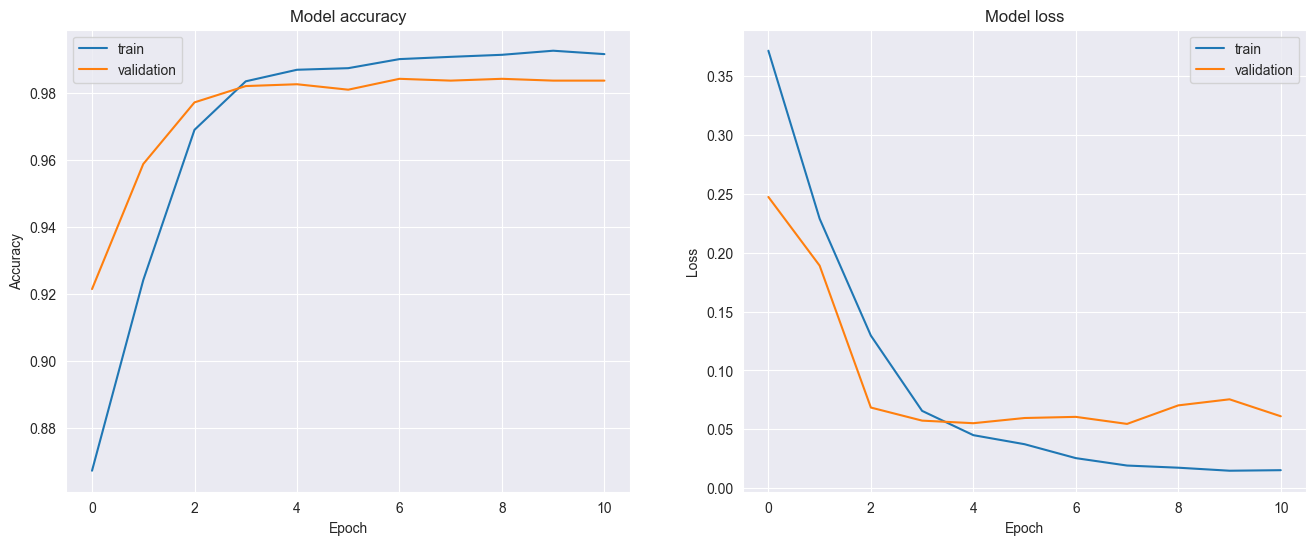

In [264]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(history[metric], label='train')
    ax[i].plot(history[f'val_{metric}'], label='validation')
    ax[i].set_title(f'Model {metric}')
    ax[i].set_ylabel(metric.title())
    ax[i].set_xlabel('Epoch')
    ax[i].legend()

plt.show()

# Export model

In [265]:
if SAVE_MODEL:
    out_path = LSTM_PATH
    lstm.save(out_path)
    print(f'[!] Model saved as {os.path.abspath(out_path)}')

INFO:tensorflow:Assets written to: ..\models\LSTM\assets


INFO:tensorflow:Assets written to: ..\models\LSTM\assets


[!] Model saved as d:\PyCharm Professional\Projects\MachineLearningPhishing\models\LSTM


In [5]:
lstm_test = tf.keras.models.load_model(LSTM_PATH)
testing_path = '../testing'
os.path.abspath(testing_path)

'd:\\PyCharm Professional\\Projects\\MachineLearningPhishing\\testing'